In [1]:
# importing required libraries, modules and pretrained model 

import os
import tensorflow as tf
from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception


SEED = 42
SIZE = (224, 224)
BATCH_SIZE = 32

pd.set_option('display.max_rows', None)

In [2]:
# training and validation data

labels = pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
labels['id'] = labels['id'].apply(lambda x: x + '.jpg')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


<AxesSubplot:>

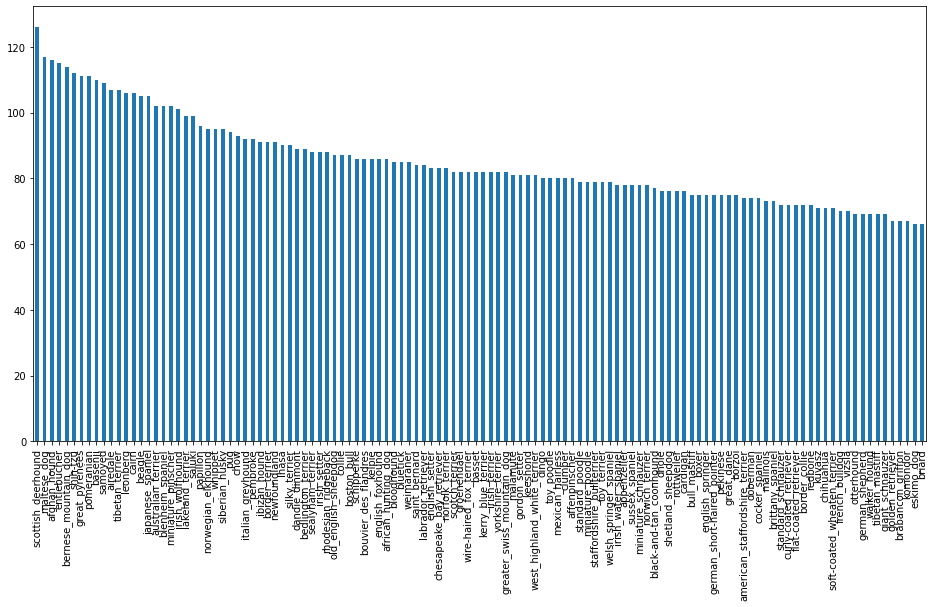

In [4]:
labels['breed'].value_counts().plot.bar(figsize=(16, 8))

****The data distribution is kind of ok. Maybe some data augmentaion to increase the lower quantity classes can be useful. Hopefully this part will be added to the notebook soon.****

In [5]:
# ImageDatagenerator to load the images in batches and perform data augmentation

data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [6]:
train_generator = data_generator.flow_from_dataframe(labels, directory='../input/dog-breed-identification/train/', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')
val_generator = data_generator.flow_from_dataframe(labels, directory='../input/dog-breed-identification/train/', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='validation')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


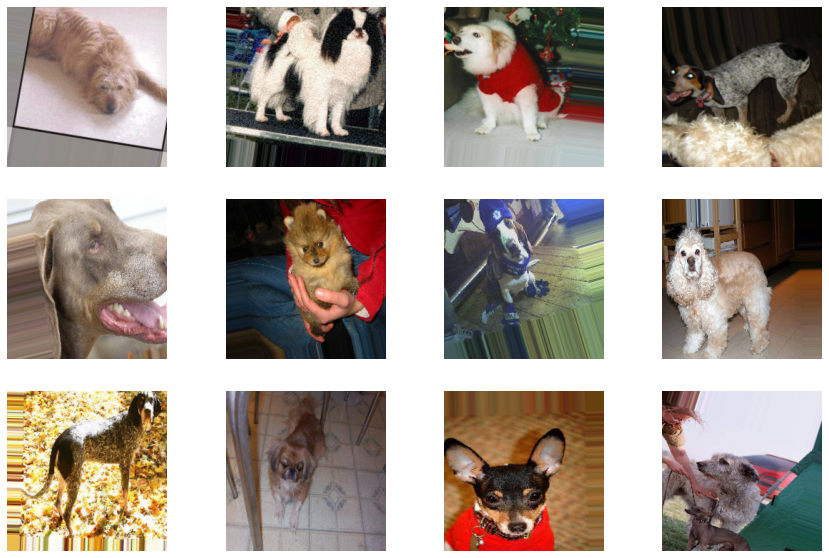

In [7]:
# 12 images after augmentation

img, label = next(train_generator)

fig = plt.figure(figsize=(15, 10))

for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')

In [8]:
# callbacks that will be used during training

early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
checkpoint = ModelCheckpoint(filepath = './weights.hdf5', verbose=1, save_best_only=True)\

****The pretrained Xeption model on the imagenet dataset will be used. The Inception and ResNet models were also tried but have not performed better.****

In [9]:
base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

2022-03-30 13:44:56.647861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:44:56.760227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:44:56.760922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:44:56.761997: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
head_model = AveragePooling2D(pool_size=(4, 4))(base_model.output)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(120, activation='softmax')(head_model)

In [12]:
model = Model(inputs=base_model.input, outputs=head_model)
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

**The model will be trained in 3 cycles. The first cycle only the added classifier's layers to the network "head_model" will be trainable with a relativly high learing rate. During the second cycle half of the xception model's layers will be unfrozen while the third cycle all of the layers will be unfrozen. During the second and third cycles the learning rate of the optimizer will be reduced.**

In [13]:
#first cycle

history1 = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint])

2022-03-30 13:45:01.759523: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-03-30 13:45:05.253182: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - 187s 700ms/step - loss: 2.7366 - accuracy: 0.4133 - val_loss: 1.8134 - val_accuracy: 0.5837

Epoch 00001: val_loss improved from inf to 1.81340, saving model to ./weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
256/256 [==============================] - 141s 551ms/step - loss: 1.7666 - accuracy: 0.6044 - val_loss: 1.4663 - val_accuracy: 0.6404

Epoch 00002: val_loss improved from 1.81340 to 1.46627, saving model to ./weights.hdf5
Epoch 3/5
256/256 [==============================] - 138s 541ms/step - loss: 1.4296 - accuracy: 0.6598 - val_loss: 1.3055 - val_accuracy: 0.6751

Epoch 00003: val_loss improved from 1.46627 to 1.30554, saving model to ./weights.hdf5
Epoch 4/5
256/256 [==============================] - 138s 540ms/step - loss: 1.2708 - accuracy: 0.6883 - val_loss: 1.2428 - val_accuracy: 0.6991

Epoch 00004: val_loss improved from 1.30554 to 1.24279, saving model to ./weights.hdf5
Epoch 5/5
256/256 [==============================] - 140s 548ms/step - loss: 1.1523 - accuracy: 0.7091 - val_loss: 1.2296 - val_accuracy: 0.6918

Epoch 00005: val_loss improved from 1.24279 to 1.22960, saving model to ./weights.hdf5


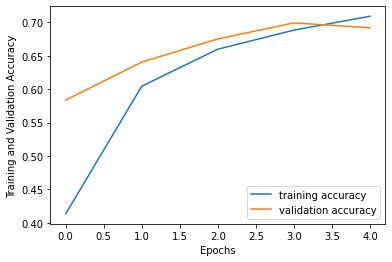

In [14]:
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

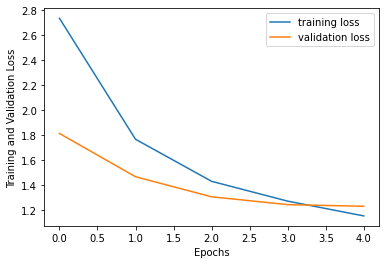

In [15]:
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

In [16]:
#second cycle

for layer in base_model.layers[len(base_model.layers)//2:]:
    layer.trainable = True

optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [17]:
history2 = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/10
256/256 [==============================] - 151s 577ms/step - loss: 1.4723 - accuracy: 0.6206 - val_loss: 1.3747 - val_accuracy: 0.6252

Epoch 00001: val_loss did not improve from 1.22960
Epoch 2/10
256/256 [==============================] - 148s 577ms/step - loss: 1.0450 - accuracy: 0.7108 - val_loss: 1.1136 - val_accuracy: 0.6898

Epoch 00002: val_loss improved from 1.22960 to 1.11364, saving model to ./weights.hdf5
Epoch 3/10
256/256 [==============================] - 147s 572ms/step - loss: 0.8144 - accuracy: 0.7608 - val_loss: 1.0869 - val_accuracy: 0.7025

Epoch 00003: val_loss improved from 1.11364 to 1.08690, saving model to ./weights.hdf5
Epoch 4/10
256/256 [==============================] - 146s 572ms/step - loss: 0.6500 - accuracy: 0.8099 - val_loss: 1.0976 - val_accuracy: 0.7162

Epoch 00004: val_loss did not improve from 1.08690
Epoch 5/10
256/256 [==============================] - 147s 573ms/step - loss: 0.5493 - accuracy: 0.8364 - val_loss: 1.0523 - val_accurac

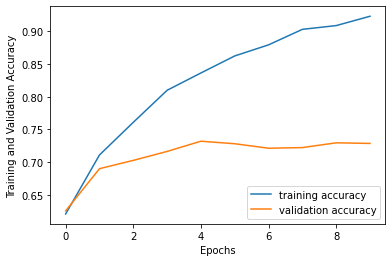

In [18]:
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

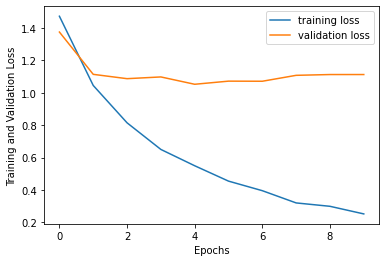

In [19]:
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

**The model clearly started overfitting after after couple of epochs so the best weights saved in the weigh.hdf5 file will be loaded before the third cycle.**

In [20]:
model.load_weights('./weights.hdf5')

In [21]:
# third cycle

for layer in base_model.layers:
    layer.trainable = True

optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [22]:
history3 = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/100
256/256 [==============================] - 180s 690ms/step - loss: 0.8437 - accuracy: 0.7584 - val_loss: 1.3112 - val_accuracy: 0.6424

Epoch 00001: val_loss did not improve from 1.05234
Epoch 2/100
256/256 [==============================] - 178s 693ms/step - loss: 0.6402 - accuracy: 0.8114 - val_loss: 1.3056 - val_accuracy: 0.6742

Epoch 00002: val_loss did not improve from 1.05234
Epoch 3/100
256/256 [==============================] - 176s 685ms/step - loss: 0.4660 - accuracy: 0.8580 - val_loss: 1.3260 - val_accuracy: 0.6771

Epoch 00003: val_loss did not improve from 1.05234
Epoch 4/100
256/256 [==============================] - 175s 682ms/step - loss: 0.3922 - accuracy: 0.8827 - val_loss: 1.2236 - val_accuracy: 0.6962

Epoch 00004: val_loss did not improve from 1.05234
Epoch 5/100
256/256 [==============================] - 177s 691ms/step - loss: 0.2952 - accuracy: 0.9055 - val_loss: 1.1698 - val_accuracy: 0.7265

Epoch 00005: val_loss did not improve from 1.05234
Epoch

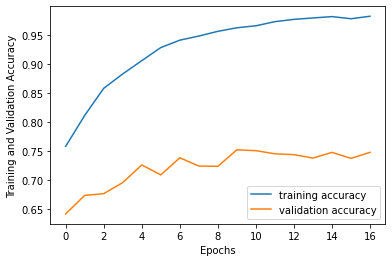

In [23]:
plt.plot(history3.history['accuracy'], label='training accuracy')
plt.plot(history3.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

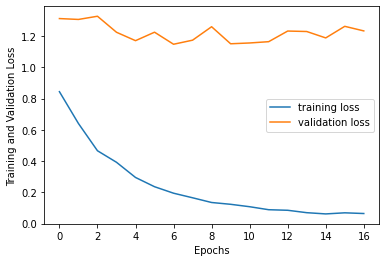

In [24]:
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

**The model performance did not improve at all so we will return to the best weights reached in the second cycle.**

In [25]:
# loading the testset

test_images_files_names = os.listdir('../input/dog-breed-identification/test/')
test_set = pd.DataFrame(test_images_files_names, columns=['id'])
test_set.head()

,id
0,09e51e17e2b756ff2ace8a87bd1443fa.jpg
1,f7a32505c12649183c5991ecfa7d68b3.jpg
2,bc6d50ffb4644feb34530aa58943e85b.jpg
3,7cbc041e79135a572aad87904b5c9c57.jpg
4,f3b603f10d6a344f0395fb46b242ff8e.jpg


In [26]:
test_data_generator = ImageDataGenerator(rescale= 1./255)
test_generator = test_data_generator.flow_from_dataframe(test_set, directory='../input/dog-breed-identification/test/', x_col='id',target_size=SIZE, class_mode=None, batch_size=BATCH_SIZE, shuffle=False)

Found 10357 validated image filenames.


In [27]:
model.load_weights('./weights.hdf5')

In [28]:
y_prop = model.predict(test_generator)

In [29]:
results = pd.DataFrame(columns=["id"] + [*train_generator.class_indices.keys()])
results

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [30]:
results["id"] = [os.path.splitext(file)[0] for file in os.listdir('../input/dog-breed-identification/test/')]
results.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
results[[*train_generator.class_indices.keys()]] = y_prop
results.head()

results.to_csv("results.csv",index=False)